In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import sklearn
import pickle
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency, pearsonr
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

**DATA PREPROCESSING**

In [2]:
# Load the dataset and handle missing values
players_df = pd.read_csv("kl.csv", encoding='latin1')

# Drop rows with missing values
df = players_df.dropna()

# Replace missing values with mean
df = players_df.fillna(players_df.mean())

# Filter outliers using IQR
numerical_columns = ['Age', 'Overall', 'Potential', 'International Reputation', 'Weak Foot', 'Skill Moves',
                   'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
                   'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
                   'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
                   'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                   'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
                   'GKKicking', 'GKPositioning', 'GKReflexes']
numerical_df = df[numerical_columns].copy()


Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ((df[numerical_columns] >= lower_bound) & (df[numerical_columns] <= upper_bound)).all(axis=1)
filtered_df = df[outlier_mask]


# Formatting the data and encoding categorical variables
# Convert categorical variables to appropriate data types
df['Nationality'] = df['Nationality'].astype('category')
df['Club'] = df['Club'].astype('category')
df['Preferred Foot'] = df['Preferred Foot'].astype('category')
df['Work Rate'] = df['Work Rate'].astype('category')
df['Body Type'] = df['Body Type'].astype('category')
df['Position'] = df['Position'].astype('category')

# Perform one-hot encoding on categorical variables
categorical_columns = ['Nationality', 'Club', 'Preferred Foot',
                       'Work Rate', 'Position']
encoded_df = pd.get_dummies(df, columns=categorical_columns)

<ipython-input-2-8089988c33ea>:8: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df = players_df.fillna(players_df.mean())


In [3]:
players_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31.0,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94.0,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,226.5M
1,1,20801,Cristiano Ronaldo,33.0,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94.0,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,127.1M
2,2,190871,Neymar Jr,26.0,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92.0,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,228.1M
3,3,193080,De Gea,27.0,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91.0,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,138.6M
4,4,192985,K. De Bruyne,27.0,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91.0,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,196.4M


**FEATURE SCALING AND FEATURE ENGINEERING**

In [4]:
# FEATURE SCALING
numeric_columns = ['ID', 'Age', 'Overall', 'Potential', 'International Reputation', 'Weak Foot', 'Skill Moves',
                   'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
                   'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed',
                   'Agility', 'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
                   'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                   'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
                   'GKKicking', 'GKPositioning', 'GKReflexes']

for column in ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW', 'LAM', 'CAM',
               'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM',
               'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB']:
    df[column] = df[column].apply(lambda x: sum(map(int, str(x).split('+'))) if isinstance(x, str) else x).astype(float)

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[numeric_columns])
scaled_df = pd.DataFrame(scaled_features, columns=numeric_columns)
players_df = pd.concat([df, scaled_df], axis=1)

# FEATURE ENGINEERING
forward_rating = ['LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW']
players_df['Attack Rating'] = players_df[forward_rating].mean(axis=1)
players_df['Attack Rating'].fillna(0, inplace=True)

midfield_rating = ['LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM', 'CDM', 'RDM', 'RWB']
players_df['Midfield Rating'] = players_df[midfield_rating].mean(axis=1)
players_df['Midfield Rating'].fillna(0, inplace=True)

defense_rating = ['LB', 'LCB', 'CB', 'RCB', 'RB']
players_df['Defense Rating'] = players_df[defense_rating].mean(axis=1)
players_df['Defense Rating'].fillna(0, inplace=True)

goalkeeper_rating = ['GKDiving', 'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']
players_df['GK Rating'] = players_df[goalkeeper_rating].mean(axis=1) * 2
players_df['GK Rating'].fillna(0, inplace=True)


# Save the preprocessed dataset to a new CSV file
players_df.to_csv("cleandataset.csv", index=False)

**VISUALIZE THE CLEAN DATASET**

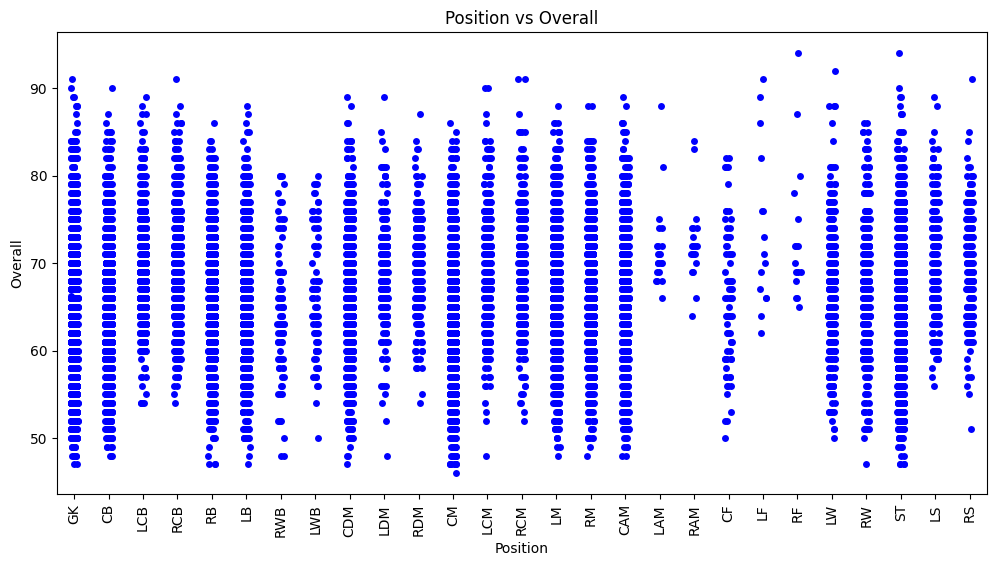

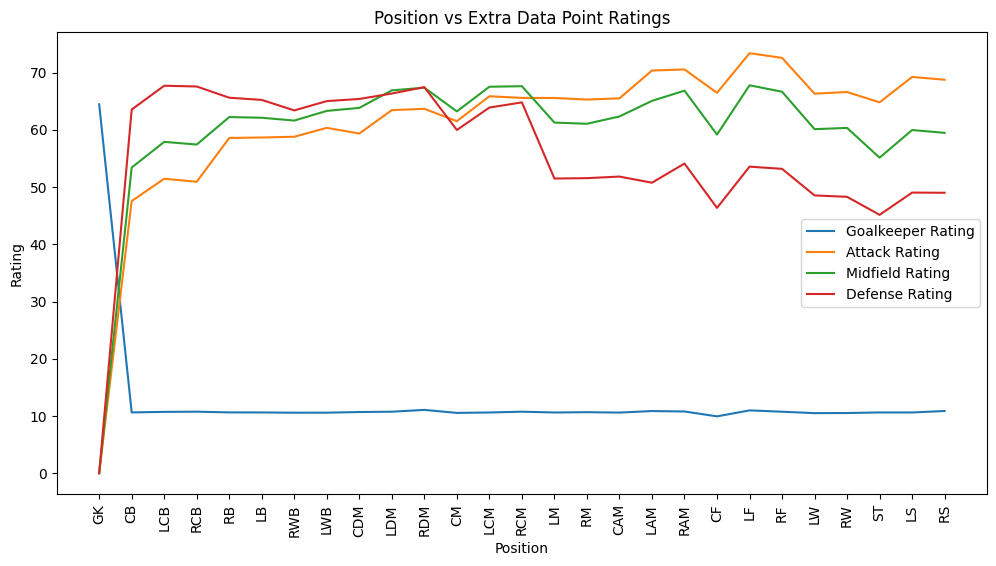

In [5]:
players_df = pd.read_csv("cleandataset.csv")
position_order = ['GK', 'CB', 'LCB', 'RCB', 'RB', 'LB', 'RWB', 'LWB', 'CDM', 'LDM', 'RDM', 'CM',
                 'LCM', 'RCM', 'LM', 'RM', 'CAM', 'LAM', 'RAM', 'CF', 'LF', 'RF', 'LW', 'RW', 'ST', 'LS', 'RS']
players_df['Position'] = pd.Categorical(players_df['Position'], categories=position_order, ordered=True)

# Strip plot: Position vs Overall
plt.figure(figsize=(12, 6))
sns.stripplot(data=players_df, x='Position', y='Overall', color='blue')
plt.title('Position vs Overall')
plt.xlabel('Position')
plt.ylabel('Overall')
plt.xticks(rotation=90)
plt.show()

# Line plot: Position vs Ratings
plt.figure(figsize=(12, 6))
plt.plot(position_order, players_df.groupby('Position')['GK Rating'].mean(), label='Goalkeeper Rating')
plt.plot(position_order, players_df.groupby('Position')['Attack Rating'].mean(), label='Attack Rating')
plt.plot(position_order, players_df.groupby('Position')['Midfield Rating'].mean(), label='Midfield Rating')
plt.plot(position_order, players_df.groupby('Position')['Defense Rating'].mean(), label='Defense Rating')

plt.title('Position vs Extra Data Point Ratings')
plt.xlabel('Position')
plt.ylabel('Rating')
plt.xticks(rotation=90)
plt.legend()
plt.show()

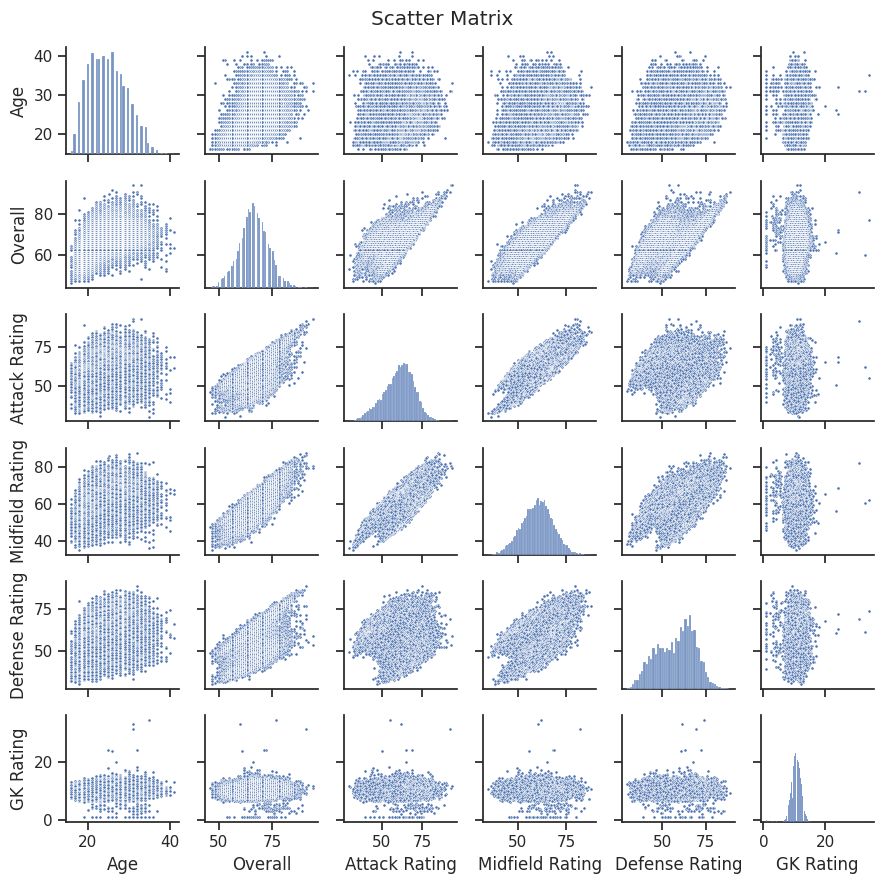

In [6]:
#SCATTER PLOT/ PAIR PLOTS
players_df = pd.read_csv("cleandataset.csv")
scatter_vars = ['Age', 'Overall', 'Attack Rating', 'Midfield Rating', 'Defense Rating', 'GK Rating']

# Filter out rows with 0 values in any of the scatter variables
filtered_df = players_df[(players_df[scatter_vars] != 0).all(axis=1)]


sns.set(style='ticks')
sns.pairplot(filtered_df[scatter_vars], diag_kind='hist', markers='.', plot_kws={'s': 20}, height=1.5)
plt.suptitle('Scatter Matrix')
plt.tight_layout()
plt.show()

**FEATURE SELECTION**

In [7]:
# Implement feature selection using Univariate Selection
players_df = pd.read_csv("cleandataset.csv", encoding='latin1')

selected_features = [ 'Age', 'Overall', 'Potential', 'Work Rate', 'Body Type',  'Interceptions', 'Finishing', 'ShotPower',
                     'Crossing', 'ShortPassing', 'Marking', 'Acceleration', 'Stamina', 'Strength', 'Nationality',
                     'Club', 'Position', 'Attack Rating', 'Midfield Rating', 'Defense Rating', 'GK Rating']
selected_df = players_df[selected_features].copy()

# Rename the 'Potential' column to 'Performance'
selected_df.rename(columns={'Potential': 'Performance'}, inplace=True)

# Select numerical columns for correlation analysis
numerical_columns = ['Age', 'Overall', 'Performance','Interceptions', 'Finishing', 'ShotPower', 'Crossing', 'ShortPassing',
                     'Marking', 'Acceleration', 'Stamina', 'Strength', 'Attack Rating', 'Midfield Rating', 'Defense Rating',
                     'GK Rating']

selected_df[numerical_columns] = selected_df[numerical_columns].apply(pd.to_numeric, errors='coerce')

# Handle infinite and NaN values by replacing them with 0
selected_df.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

# Function to calculate correlation coefficient and p-value
def calculate_corr_pval(x, y):
    corr, p_val = pearsonr(x, y)
    return corr, p_val

# Perform correlation analysis for numerical variables
numerical_features = selected_df[numerical_columns]
target_variable = selected_df['Performance']

numerical_scores = []
for column in numerical_columns:
    corr, p_val = calculate_corr_pval(numerical_features[column], target_variable)
    numerical_scores.append((column, abs(corr), p_val))

# Sort by absolute correlation coefficient
numerical_scores.sort(key=lambda x: x[1], reverse=True)
selected_numerical_features = [score[0] for score in numerical_scores[:16]]


selected_df = selected_df[selected_numerical_features]
print(selected_df)
selected_df.to_csv('selected_dataset.csv', index=False)

players_df = pd.read_csv('selected_dataset.csv')
players_df.head(10)

       Performance  Overall  ShortPassing  ShotPower  Attack Rating  \
0               94     94.0          90.0       85.0         92.875   
1               94     94.0          81.0       95.0         93.125   
2               93     92.0          84.0       80.0         90.125   
3               93     91.0          50.0       31.0          0.000   
4               92     91.0          92.0       91.0         88.125   
...            ...      ...           ...        ...            ...   
18202           65     47.0          49.0       43.0         45.250   
18203           63     47.0          43.0       41.0         44.375   
18204           67     47.0          38.0       45.0         47.375   
18205           66     47.0          42.0       64.0         48.625   
18206           66     46.0          48.0       43.0         45.875   

       Midfield Rating   Age  Crossing  Finishing  Acceleration  Stamina  \
0            80.769231  31.0      84.0       95.0          91.0     72.

,Performance,Overall,ShortPassing,ShotPower,Attack Rating,Midfield Rating,Age,Crossing,Finishing,Acceleration,Stamina,Defense Rating,Marking,Interceptions,Strength,GK Rating
0,94,94.0,90.0,85.0,92.875,80.769231,31.0,84.0,95.0,91.0,72.0,53.8,33.0,22.0,59.0,10.908592
1,94,94.0,81.0,95.0,93.125,79.615385,33.0,84.0,94.0,89.0,88.0,59.2,28.0,29.0,79.0,11.717291
2,93,92.0,84.0,80.0,90.125,79.615385,26.0,79.0,87.0,94.0,81.0,55.2,27.0,36.0,49.0,11.919637
3,93,91.0,50.0,31.0,0.000,0.000000,27.0,17.0,13.0,57.0,43.0,0.0,15.0,30.0,64.0,89.771232
4,92,91.0,92.0,91.0,88.125,86.538462,27.0,93.0,82.0,78.0,90.0,71.8,68.0,61.0,75.0,11.312754
5,91,91.0,89.0,82.0,89.375,80.846154,27.0,81.0,84.0,94.0,83.0,56.4,34.0,41.0,66.0,9.088543
6,91,91.0,93.0,79.0,84.625,87.923077,32.0,86.0,72.0,80.0,89.0,77.2,60.0,83.0,58.0,10.504300
7,91,91.0,82.0,86.0,91.750,82.076923,31.0,77.0,93.0,86.0,90.0,69.2,62.0,41.0,83.0,30.927170
8,91,91.0,78.0,79.0,74.500,79.615385,32.0,66.0,60.0,76.0,84.0,88.8,87.0,90.0,83.0,9.290623
9,93,90.0,29.0,22.0,0.000,0.000000,25.0,13.0,11.0,43.0,41.0,0.0,27.0,19.0,78.0,87.546875


**TRAIN-TEST SPLIT**

In [8]:
# Identify non-numeric columns
non_numeric_columns = selected_df.select_dtypes(exclude=[np.number]).columns

# Exclude non-numeric columns from the dataset
selected_numeric_df = selected_df.drop(non_numeric_columns, axis=1)

# Perform one-hot encoding for categorical columns
encoded_df = pd.get_dummies(selected_numeric_df)

X = encoded_df.drop('Performance', axis=1)
y = encoded_df['Performance']

# Perform feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape, y_train.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (14565, 15) (14565,)
Testing set shape: (3642, 15) (3642,)


**MODEL CONSTRUCTION AND COMPARISON**

Linear Regression Mean Squared Error: 6.194083799449001
Linear Regression Execution Time: 0.05678105354309082
Decision Tree Mean Squared Error: 5.229101836597718
Decision Tree Execution Time: 0.23787212371826172
Random Forest Mean Squared Error: 2.835308870666468
Random Forest Execution Time: 11.711214065551758
The best model based on MSE is: Random Forest


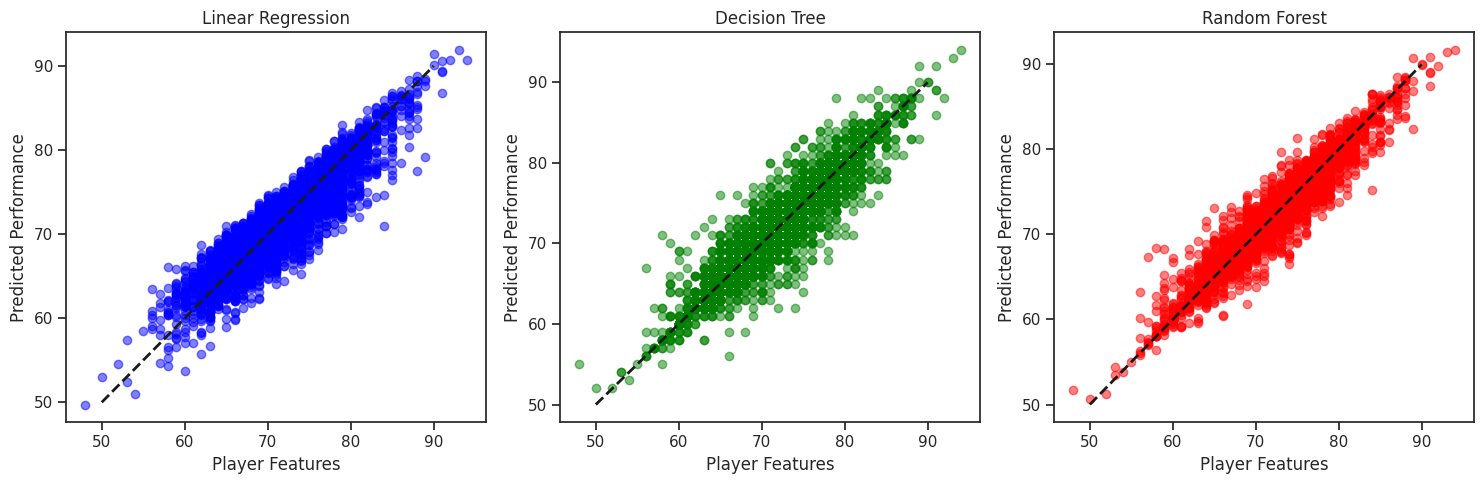

<Figure size 640x480 with 0 Axes>

In [9]:
# LINEAR REGRESSION MODEL
start_time = time.time()
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
mse_linear = mean_squared_error(y_test, y_pred_linear)
linear_time = time.time() - start_time

print("Linear Regression Mean Squared Error:", mse_linear)
print("Linear Regression Execution Time:", linear_time)

# DECISION TREE MODEL
start_time = time.time()
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
tree_time = time.time() - start_time

print("Decision Tree Mean Squared Error:", mse_tree)
print("Decision Tree Execution Time:", tree_time)

# RANDOM FOREST MODEL
start_time = time.time()
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
mse_forest = mean_squared_error(y_test, y_pred_forest)
forest_time = time.time() - start_time

print("Random Forest Mean Squared Error:", mse_forest)
print("Random Forest Execution Time:", forest_time)

# Determine the best model based on MSE
best_model = None
best_mse = float('inf')

if mse_linear < mse_tree and mse_linear < mse_forest:
    best_model = linear_model
    best_mse = mse_linear
    best_model_name = "Linear Regression"
elif mse_tree < mse_forest:
    best_model = tree_model
    best_mse = mse_tree
    best_model_name = "Decision Tree"
else:
    best_model = forest_model
    best_mse = mse_forest
    best_model_name = "Random Forest"

print("The best model based on MSE is:", best_model_name)

# Save the best trained model
import pickle
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Scatter plot for Linear Regression
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_linear, color='blue', alpha=0.5)
plt.plot([50, 90], [50, 90], 'k--', lw=2)
plt.xlabel('Player Features')
plt.ylabel('Predicted Performance')
plt.title('Linear Regression')
plt.xticks([50, 60, 70, 80, 90])
plt.yticks([50, 60, 70, 80, 90])

# Scatter plot for Decision Tree
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_tree, color='green', alpha=0.5)
plt.plot([50, 90], [50, 90], 'k--', lw=2)
plt.xlabel('Player Features')
plt.ylabel('Predicted Performance')
plt.title('Decision Tree')
plt.xticks([50, 60, 70, 80, 90])
plt.yticks([50, 60, 70, 80, 90])

# Scatter plot for Random Forest
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_forest, color='red', alpha=0.5)
plt.plot([50, 90], [50, 90], 'k--', lw=2)
plt.xlabel('Player Features')
plt.ylabel('Predicted Performance')
plt.title('Random Forest')
plt.xticks([50, 60, 70, 80, 90])
plt.yticks([50, 60, 70, 80, 90])

plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()

**HYPER PARAMETER TUNING**

In [10]:
# Hyperparameter tuning for Decision Tree
tree_param_grid = {
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
tree_search = RandomizedSearchCV(tree_model, param_distributions=tree_param_grid, n_iter=10, cv=3)
tree_search.fit(X_train, y_train)
best_tree_model = tree_search.best_estimator_
best_tree_params = tree_search.best_params_

# Hyperparameter tuning for Random Forest
forest_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
forest_search = RandomizedSearchCV(forest_model, param_distributions=forest_param_grid, n_iter=10, cv=3)
forest_search.fit(X_train, y_train)
best_forest_model = forest_search.best_estimator_
best_forest_params = forest_search.best_params_

# Evaluate the best models
y_pred_best_tree = best_tree_model.predict(X_test)
mse_best_tree = mean_squared_error(y_test, y_pred_best_tree)

y_pred_best_forest = best_forest_model.predict(X_test)
mse_best_forest = mean_squared_error(y_test, y_pred_best_forest)

print("Best Decision Tree Mean Squared Error:", mse_best_tree)
print("Best Decision Tree Hyperparameters:", best_tree_params)

print("Best Random Forest Mean Squared Error:", mse_best_forest)
print("Best Random Forest Hyperparameters:", best_forest_params)

if mse_best_tree < mse_best_forest:
    best_model = best_tree_model
    best_mse = mse_best_tree
    best_model_name = "Decision Tree"
else:
    best_model = best_forest_model
    best_mse = mse_best_forest
    best_model_name = "Random Forest"

print("The best model based on MSE is:", best_model_name)

with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_tree_model, file)

Best Decision Tree Mean Squared Error: 3.2890269172514057
Best Decision Tree Hyperparameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10}
Best Random Forest Mean Squared Error: 2.7348968357157353
Best Random Forest Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
The best model based on MSE is: Random Forest


**REAL-TIME PREDICTION AND VISUALIZATION**

In [11]:
# Load the best trained model
with open('best_model.pkl', 'rb') as f:
    best_tree_model = pickle.load(f)

# User input for feature values
Age = float(input("Enter Age: "))
Overall = float(input("Enter Overall: "))
Interceptions = float(input("Enter Interceptions: "))
Finishing = float(input("Enter Finishing: "))
ShotPower = float(input("Enter ShotPower: "))
Crossing = float(input("Enter Crossing: "))
ShortPassing = float(input("Enter ShortPassing: "))
Marking = float(input("Enter Marking: "))
Acceleration = float(input("Enter Acceleration: "))
Stamina = float(input("Enter Stamina: "))
Strength = float(input("Enter Strength: "))
attack_rating = float(input("Enter Attack Rating: "))
midfield_rating = float(input("Enter Midfield Rating: "))
defense_rating = float(input("Enter Defense Rating: "))
gk_rating = float(input("Enter GK Rating: "))

# Prepare the input data for prediction
input_data = [[Age, Overall, Interceptions, Finishing, ShotPower, Crossing, ShortPassing, Marking, Acceleration, Stamina,
               Strength, attack_rating, midfield_rating, defense_rating, gk_rating]]

# Make the prediction using the trained model
predicted_performance = best_model.predict(input_data)

# Print the predicted performance rating rounded to 2 decimal places
print(f"The Predicted Performance Rating is: {round(predicted_performance[0], 2)}")

Enter Age: 23
Enter Overall: 88
Enter Interceptions: 87
Enter Finishing: 89
Enter ShotPower: 90
Enter Crossing: 78
Enter ShortPassing: 98
Enter Marking: 83
Enter Acceleration: 84
Enter Stamina: 81
Enter Strength: 80
Enter Attack Rating: 89
Enter Midfield Rating: 80
Enter Defense Rating: 75
Enter GK Rating: 23
The Predicted Performance Rating is: 91.65


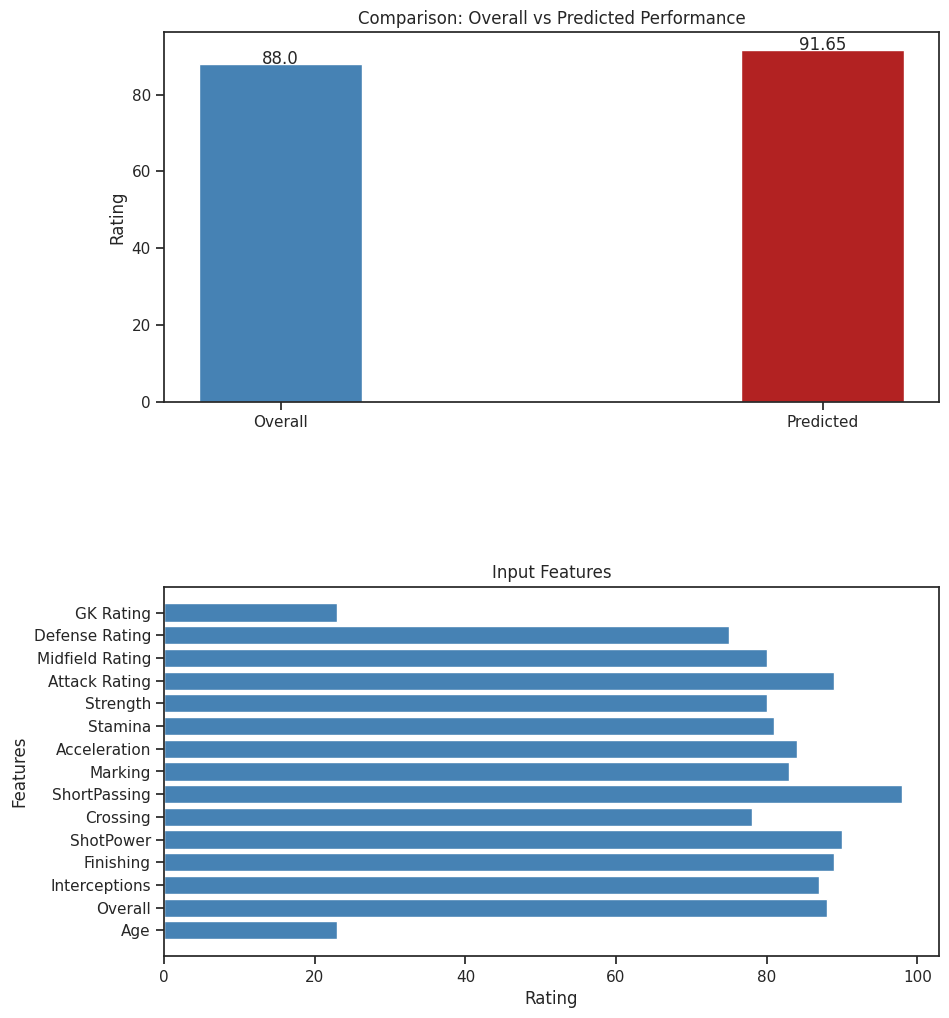

In [16]:
# Define the feature names and values
feature_names = ['Age', 'Overall', 'Interceptions', 'Finishing', 'ShotPower', 'Crossing', 'ShortPassing', 'Marking',
                 'Acceleration', 'Stamina', 'Strength', 'Attack Rating', 'Midfield Rating', 'Defense Rating',
                 'GK Rating']
feature_values = [Age, Overall, Interceptions, Finishing, ShotPower, Crossing, ShortPassing, Marking, Acceleration,
                  Stamina, Strength, attack_rating, midfield_rating, defense_rating, gk_rating]

# Create the subplots and figure
fig, axs = plt.subplots(nrows=2, figsize=(10, 12))

# Plot the bar plot (Input Features)
axs[1].barh(feature_names, feature_values, color='steelblue')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Features')
axs[1].set_title('Input Features')

# Plot the bar plot (Comparison: Overall vs Predicted Performance)
x_values = ['Overall', 'Predicted']
y_values = [Overall, round(predicted_performance[0], 2)]  # Round off to 2 decimal places
axs[0].bar(x_values, y_values, color=['steelblue', 'firebrick'], width=0.3)
axs[0].set_ylabel('Rating')
axs[0].set_title('Comparison: Overall vs Predicted Performance')
axs[0].text(0, Overall + 0.1, str(Overall), ha='center')
axs[0].text(1, round(predicted_performance[0], 2) + 0.1, str(round(predicted_performance[0], 2)), ha='center')  # Round off to 2 decimal places

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()

**EXTRA FEATURE: GENERATE REPORT**

Do you want to open the report? (yes/no): no


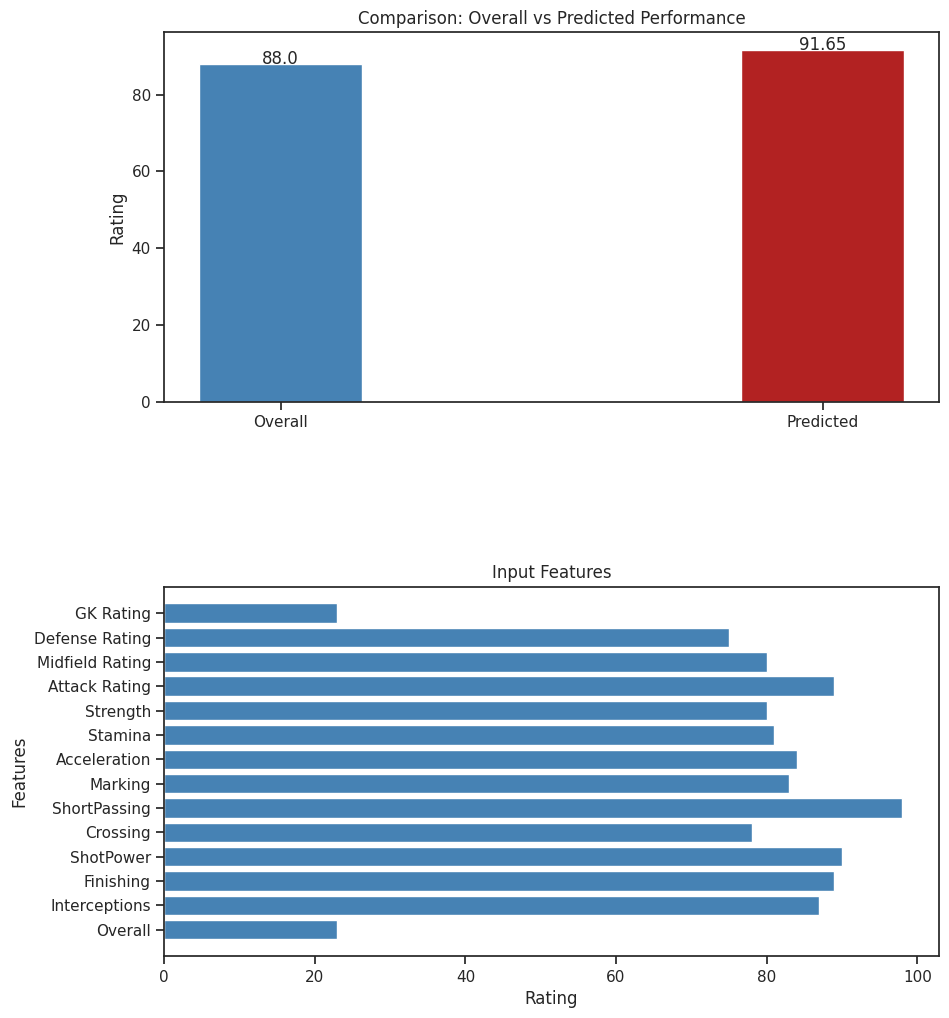

In [18]:
import matplotlib.backends.backend_pdf as pdf

# Generate the report text
report_text = "Input Features:\n\n"
input_features = [
    ("Age", Age),
    ("Overall", Overall),
    ("Interceptions", Interceptions),
    ("Finishing", Finishing),
    ("ShotPower", ShotPower),
    ("Crossing", Crossing),
    ("ShortPassing", ShortPassing),
    ("Marking", Marking),
    ("Acceleration", Acceleration),
    ("Stamina", Stamina),
    ("Strength", Strength),
    ("Attack Rating", attack_rating),
    ("Midfield Rating", midfield_rating),
    ("Defense Rating", defense_rating),
    ("GK Rating", gk_rating)
]

for feature_name, feature_value in input_features:
    report_text += f"{feature_name}: {feature_value}\n"
report_text += f"Predicted Performance Rating: {round(predicted_performance[0], 2)}\n"

# Create a PDF file
with pdf.PdfPages('Report.pdf') as pdf_file:
    # Generate the figure
    fig, axs = plt.subplots(nrows=2, figsize=(10, 12))

    # Plot the bar plot (Input Features)
    feature_names = ['Age', 'Overall', 'Interceptions', 'Finishing', 'ShotPower', 'Crossing', 'ShortPassing', 'Marking',
                     'Acceleration', 'Stamina', 'Strength', 'Attack Rating', 'Midfield Rating', 'Defense Rating',
                     'GK Rating']
    feature_values = [Age, Overall, Interceptions, Finishing, ShotPower, Crossing, ShortPassing, Marking, Acceleration,
                      Stamina, Strength, attack_rating, midfield_rating, defense_rating, gk_rating]
    feature_values.pop(1)  # Remove 'Overall' value
    axs[1].barh(feature_names[1:], feature_values, color='steelblue')
    axs[1].set_xlabel('Rating')
    axs[1].set_ylabel('Features')
    axs[1].set_title('Input Features')

    # Plot the bar plot (Comparison: Overall vs Predicted Performance)
    x_values = ['Overall', 'Predicted']
    y_values = [Overall, round(predicted_performance[0], 2)]
    axs[0].bar(x_values, y_values, color=['steelblue', 'firebrick'], width=0.3)
    axs[0].set_ylabel('Rating')
    axs[0].set_title('Comparison: Overall vs Predicted Performance')
    axs[0].text(0, Overall + 0.1, str(Overall), ha='center')
    axs[0].text(1, predicted_performance[0] + 0.1, str(round(predicted_performance[0], 2)), ha='center')
    plt.subplots_adjust(hspace=0.5)

    # Save the figure to the PDF file
    pdf_file.savefig()

    # Add the report text to the PDF file
    plt.figure(figsize=(8, 10))
    plt.text(0.1, 0.1, report_text, fontsize=12)
    plt.axis('off')
    pdf_file.savefig()

    # Close the figure
    plt.close()

# Prompt the user if they want to open or download the report
open_report = input("Do you want to open the report? (yes/no): ")

if open_report.lower() == "yes":
    # Open the generated report file
    import webbrowser
    webbrowser.open('Report.pdf')
    print("Report generated successfully.")